In [1]:
import sys
sys.path.append("../src/")
import utils as ut
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import integration as itg
import mittag_leffler as ml
from fLe import fle

data_path = "../data/fle/"
plt.style.use("plot_style.mplstyle")

# FRACTIONAL LANGEVIN EQUATION: Solution

In [2]:
def line(t):
    return t

def first_guess(t, noise, x0, v0):
    t_ = np.array(t)
    noise_ = np.array(noise)
    return x0 + v0*t_ + itg.convolution(line, noise_, t_)

In [3]:
# Next-guess algorithm
def inspect_nga(H, N, id):
    
    return ut.read_hdf5_data(f"{data_path}fle-h-{H}-{N}-{id}.hdf5")

In [4]:
# Finite differences
def inspect_fd(H, N, T, id):
    path = (f"{data_path}fBM-h-{H}-{id}.hdf5")
    noise_path = (f"{data_path}fle-h-{H}-noise-{N}-{id}.hdf5")
    BH = ut.read_hdf5_data(path)
    dBH = ut.read_hdf5_data(noise_path)
    
    t = dBH.deets_t
    noise = dBH.deets_v
    
    x0 = 0
    v0 = 0
    delta_t = T/N
    first_guess_ = first_guess(t, noise, x0, v0)
    
    eq = fle(H)
    eq.params(T, h = delta_t, v0 = first_guess_[2]/delta_t)
    eq.external_B_H(np.array(BH.deets_v), t)
    eq.get_analytical()
    eq.solve()
    
    return eq


In [5]:
def plot_comparison(H, N, T, id, ax):
    nga = inspect_nga(H, N, id)
    eq = inspect_fd(H, N, T, id)

    ax.plot(nga.deets_t, nga.deets_v, ls = "", marker = "*", label = "Next-guess algorithm")
    ax.plot(eq.t, eq.numerical, label = "Numerical")
    ax.plot(eq.t, eq.analytical, label = "Analytical", ls = "--", color = "green")
    ax.set_title("Next-guess algorithm")
    ax.legend();

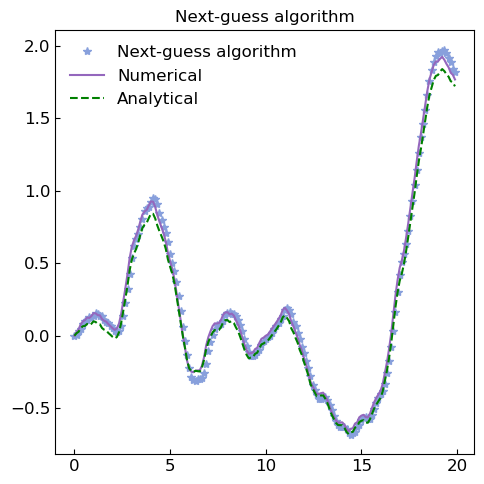

In [6]:
H = 0.6
N = 180
T = 20
id = 15

fig, ax = plt.subplots(figsize = (5, 5))
plot_comparison(H, N, T, id, ax)

SOLVED: The scaling difference between both algorithms came from the difference in the definition of the noises. For the NGA it was used T/N, while for finite differences it was used 1/(T/N) which actually corresponds to 1/h. This is the right definition.

NOTE: Both algorithms are comparable so far only when $\zeta = 1$. However, the scaling factor used to fit the MSD is $\zeta = 3 - 2H$